<a href="https://colab.research.google.com/github/Pooya-Moayed/Reinforced-Learning/blob/Mixing-Tank/PRNN_Mixing_Tank_2_Physics_Term.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Reinforced Neural Networks**

in this code snippet i tried to make a neural networks algorithem which is reinforced by applying two physical terms in the loss function using a derivatives of the terms.

##**1. Importing the dataset and the used libraries**



In [1]:
# importing the Libraries
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
import torch
# import tqdm

import torch.nn as nn
import torch.optim as optim

##**Computational Fluid Dynamics : Mixing Tank**
The topic is to predict the mixing quality inside a two-phase solid-liquid mixing tank (mechanically stirred vessel). X1 to X78 are the inputs and Y is the output to predict (a dimensionless number quantifying the mixing quality, low : high quality, high : low quality). X1 to X8 are raw inputs. In order : tank and agitator design, stirring speed, tank diameter, solid particle diameter, solid density, liquid density, liquid dynamic viscosity and mean solid volume fraction. X9 to X78 are additional features constructed with physical meaning (such as dimensionless numbers and correlations from the literature) from X1 to X8 to 'assist' machine learning (X9 to X78 are hence feature engineering). X1 is a qualitative input about the tank and impeller design. The data are generated with Computational Fluid Dynamics calculations performed with a ANSYS FLUENT model (finite volumes method) that was validated against experimental data. The ANSYS FLUENT model is based on RANS turbulent Euler Granular theory. All variables are normalized between 0 and 1. A baseline performance can be a Mean Absolute Error of 0.0167 with the additional features (X9 to X78) and a Mean Absolute Error of 0.0282 with raw inputs only (X1 to X8). Feel free to discuss :) More info here : https://www.researchgate.net/publication/327059961_Solid-Liquid_Mixing_in_Stirred_Vessels_Numerical_Simulation_Experimental_Validation_and_Suspension_Quality_Prediction_Using_Multivariate_Regression_and_Machine_Learning

In [2]:
import kagglehub
import os

# Download latest version
path = kagglehub.dataset_download("comacque/computational-fluid-dynamics-mixing-tank")

print("Path to dataset files:", path)

100%|██████████| 236k/236k [00:00<00:00, 43.3MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/comacque/computational-fluid-dynamics-mixing-tank/versions/1


In [3]:
# List all files in the dataset
for file in os.listdir(path):
    print(file)

kaggle-cfd-mixing-tank.csv


In [4]:
path

'/root/.cache/kagglehub/datasets/comacque/computational-fluid-dynamics-mixing-tank/versions/1'



###    Data Preprocessing:






In [5]:
file_path = os.path.join(path, "kaggle-cfd-mixing-tank.csv")
dataset = pd.read_csv(file_path, sep='\t')
print(dataset)

             X1        X2        X3        X4        X5        X6        X7  \
0      Design 1  0.320113  0.034127  0.042394  0.068433  0.303030  0.469821   
1      Design 1  0.320113  0.034127  0.142145  0.068433  0.303030  0.469821   
2      Design 1  0.320113  0.034127  0.291771  0.068433  0.303030  0.469821   
3      Design 1  0.320113  0.034127  0.441397  0.068433  0.303030  0.469821   
4      Design 1  0.320113  0.034127  0.591022  0.068433  0.303030  0.469821   
...         ...       ...       ...       ...       ...       ...       ...   
1009  Design 14  0.150142  0.051835  0.082294  0.061840  0.151515  0.429038   
1010  Design 14  0.192635  0.051835  0.082294  0.061840  0.151515  0.429038   
1011  Design 14  0.235127  0.051835  0.082294  0.061840  0.151515  0.429038   
1012  Design 14  0.277620  0.051835  0.082294  0.061840  0.151515  0.429038   
1013  Design 14  0.320113  0.051835  0.082294  0.061840  0.151515  0.429038   

            X8        X9       X10  ...       X70  

In [6]:
# Rename the first 8 columns
dataset.columns = [
    "tank and agitator design",
    "stirring speed",
    "tank diameter",
    "solid particle diameter",
    "solid density",
    "liquid density",
    "liquid dynamic viscosity",
    "mean solid volume fraction",
] + list(dataset.columns[8:])  # keep the rest unchanged

# Check the result
print(dataset.head())

  tank and agitator design  stirring speed  tank diameter  \
0                 Design 1        0.320113       0.034127   
1                 Design 1        0.320113       0.034127   
2                 Design 1        0.320113       0.034127   
3                 Design 1        0.320113       0.034127   
4                 Design 1        0.320113       0.034127   

   solid particle diameter  solid density  liquid density  \
0                 0.042394       0.068433         0.30303   
1                 0.142145       0.068433         0.30303   
2                 0.291771       0.068433         0.30303   
3                 0.441397       0.068433         0.30303   
4                 0.591022       0.068433         0.30303   

   liquid dynamic viscosity  mean solid volume fraction        X9       X10  \
0                  0.469821                    0.322034  0.859155  0.761905   
1                  0.469821                    0.322034  0.859155  0.761905   
2                  0.469821  

## **2. Data Engineering**

### Encoding the tank design and defigning X and y:

In [7]:
from sklearn.preprocessing import TargetEncoder

# Instantiate the TargetEncoder
encoder = TargetEncoder()

# Prepare X (categorical features for encoding) and y (target) for the encoder
X_categorical_for_encoding = dataset[['tank and agitator design']]
y_target_for_encoding = dataset['Y']

# Fit and transform the 'X1' column using the encoder
encoded_X1 = encoder.fit_transform(X_categorical_for_encoding, y_target_for_encoding)

# Create a copy of the original dataset to avoid modifying it directly
full_encoded_df = dataset.copy()

# Replace the original 'X1' column with its target-encoded values
full_encoded_df['tank and agitator design'] = encoded_X1

print("Full encoded DataFrame:")
print(full_encoded_df)

# Define X and y from the full_encoded_df
X = full_encoded_df.drop(columns=['Y'])
y = full_encoded_df['Y']

Full encoded DataFrame:
      tank and agitator design  stirring speed  tank diameter  \
0                     0.188784        0.320113       0.034127   
1                     0.198860        0.320113       0.034127   
2                     0.198664        0.320113       0.034127   
3                     0.198860        0.320113       0.034127   
4                     0.188784        0.320113       0.034127   
...                        ...             ...            ...   
1009                  0.204408        0.150142       0.051835   
1010                  0.345815        0.192635       0.051835   
1011                  0.204408        0.235127       0.051835   
1012                  0.345815        0.277620       0.051835   
1013                  0.345815        0.320113       0.051835   

      solid particle diameter  solid density  liquid density  \
0                    0.042394       0.068433        0.303030   
1                    0.142145       0.068433        0.303030   
2  

In [8]:
print(X)
print(y)

      tank and agitator design  stirring speed  tank diameter  \
0                     0.188784        0.320113       0.034127   
1                     0.198860        0.320113       0.034127   
2                     0.198664        0.320113       0.034127   
3                     0.198860        0.320113       0.034127   
4                     0.188784        0.320113       0.034127   
...                        ...             ...            ...   
1009                  0.204408        0.150142       0.051835   
1010                  0.345815        0.192635       0.051835   
1011                  0.204408        0.235127       0.051835   
1012                  0.345815        0.277620       0.051835   
1013                  0.345815        0.320113       0.051835   

      solid particle diameter  solid density  liquid density  \
0                    0.042394       0.068433        0.303030   
1                    0.142145       0.068433        0.303030   
2                    0.2917

In [9]:
# reshaping to the format suitable for tourch tensor for vectorisation
X = full_encoded_df.drop(columns=['Y']).iloc[:, :-1].values
X

array([[1.88783634e-01, 3.20113314e-01, 3.41274950e-02, ...,
        1.50547000e-03, 7.09645370e-02, 5.07805720e-02],
       [1.98860498e-01, 3.20113314e-01, 3.41274950e-02, ...,
        4.77537000e-04, 3.42285960e-02, 1.86575110e-02],
       [1.98664444e-01, 3.20113314e-01, 3.41274950e-02, ...,
        2.09833000e-04, 1.95305610e-02, 8.74447600e-03],
       ...,
       [2.04407981e-01, 2.35127479e-01, 5.18351580e-02, ...,
        7.16269000e-04, 4.39876430e-02, 2.75713570e-02],
       [3.45814850e-01, 2.77620397e-01, 5.18351580e-02, ...,
        9.15099000e-04, 5.39778560e-02, 3.23909050e-02],
       [3.45814850e-01, 3.20113314e-01, 5.18351580e-02, ...,
        1.12731700e-03, 6.39680690e-02, 3.71364000e-02]])

In [10]:
y = full_encoded_df['Y'].values.reshape(-1, 1)
print(y.shape)
print(y[:5])

(1014, 1)
[[0.01967153]
 [0.15348866]
 [0.27954987]
 [0.39339303]
 [0.47545339]]


### separate train and test values

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Train Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalization
scalarX, scalary = StandardScaler(), StandardScaler()

X_train = scalarX.fit_transform(X_train)
X_test = scalarX.transform(X_test)

y_train = scalary.fit_transform(y_train)
y_test = scalary.transform(y_test)


# convert to torch tensors
X_train = torch.tensor(X_train, dtype=torch.float32, requires_grad=True)
X_test = torch.tensor(X_test, dtype=torch.float32, requires_grad=True)
y_train = torch.tensor(y_train, dtype=torch.float32, requires_grad=True)
y_test = torch.tensor(y_test, dtype=torch.float32, requires_grad=True)

In [12]:
print(type(X_train), X_train.dtype)

<class 'torch.Tensor'> torch.float32


##**3. Model building:**

In [13]:
# Defigne the Neural Network class
class Mixing(nn.Module):
  def __init__(self, inputdim=77, hiddendim=128, targetdim=1):
    super().__init__()
    self.model = nn.Sequential(
        nn.Linear(inputdim, hiddendim),
        nn.Tanh(),
        nn.Linear(hiddendim, hiddendim),
        nn.Tanh(),
        nn.Linear(hiddendim, targetdim)
    )

  def forward(self, x):
    return self.model(x)

In [29]:
def physical_loss(x, y_pred):

  # relying on the connection between the speed and other features we select some of the features that we can use for the target

  N = torch.tensor(X[:, 1], dtype=torch.float32, requires_grad=True)  # tank diameter connected to the reynolds number
  mu = torch.tensor(X[:, 6], dtype=torch.float32, requires_grad=True) # viscosity conected to the speed of the fuid containing the particles

  # defigning the derivatives of thetarget with respect to the selected features
  dy_dN = torch.autograd.grad(
      y_pred.sum(),
      N,
      create_graph=True,
      retain_graph=True,
      only_inputs=True,
      allow_unused=True
  )[0]

  dy_dmu = torch.autograd.grad(
      y_pred.sum(),
      mu,
      create_graph=True,
      retain_graph=True,
      only_inputs=True,
      allow_unused=True
  )[0]

   # Safe fallbacks
  if dy_dN is None:
        dy_dN = torch.zeros_like(x)
  if dy_dmu is None:
        dy_dmu = torch.zeros_like(x)


  loss_physics = torch.mean((torch.relu(dy_dN))**2) + torch.mean((torch.relu(-dy_dmu))**2)

  return loss_physics


In [30]:
def total_loss(y_true, y_pred, X):
    # Data MSE loss
    mse_loss = torch.mean((y_true - y_pred) ** 2)

    # Combine both losses
    total = mse_loss + 0.1 * physical_loss(X, y_pred)
    return total

##**3. Train model**

In [37]:
# initialise model and optimizer

model = Mixing()
optimizer = optim.Adam(model.parameters(), lr=0.005)

# Training loop

epoches = 2000

for i in range(epoches):
  optimizer.zero_grad()
  y_pred = model(X_train)
  loss = total_loss(y_train, y_pred, X_train)
  loss.backward()
  optimizer.step()

  if i % 100 == 0:
    with torch.no_grad():
      test_pred = model(X_test)
      test_loss = torch.mean((y_test - test_pred) ** 2)
    print(f"Epoch {i}, Loss: {loss.item()}")

Epoch 0, Loss: 0.9989296793937683
Epoch 100, Loss: 0.023292342200875282
Epoch 200, Loss: 0.009393888525664806
Epoch 300, Loss: 0.0051784939132630825
Epoch 400, Loss: 0.003624284639954567
Epoch 500, Loss: 0.002528551733121276
Epoch 600, Loss: 0.002006752882152796
Epoch 700, Loss: 0.001521620200946927
Epoch 800, Loss: 0.0014299120521172881
Epoch 900, Loss: 0.0010752144735306501
Epoch 1000, Loss: 0.0009102777112275362
Epoch 1100, Loss: 0.006930847652256489
Epoch 1200, Loss: 0.0007088498095981777
Epoch 1300, Loss: 0.0006262579699978232
Epoch 1400, Loss: 0.000591639953199774
Epoch 1500, Loss: 0.0005207492504268885
Epoch 1600, Loss: 0.006984889041632414
Epoch 1700, Loss: 0.0004401956684887409
Epoch 1800, Loss: 0.0003957837470807135
Epoch 1900, Loss: 0.0003578672476578504


## **4. Evaluation

Mean Absolute Error:  0.021605797


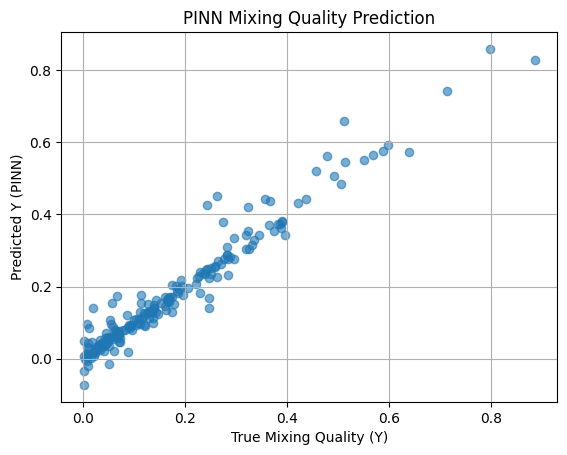

In [38]:
with torch.no_grad():
  y_pred_test = model(X_test)
  y_pred_test = scalary.inverse_transform(y_pred_test.numpy())
  y_true_test = scalary.inverse_transform(y_test.numpy())

mae = np.mean(np.abs(y_true_test - y_pred_test))
print("Mean Absolute Error: ", mae)


plt.scatter(y_true_test, y_pred_test, alpha=0.6)
plt.xlabel("True Mixing Quality (Y)")
plt.ylabel("Predicted Y (PINN)")
plt.title("PINN Mixing Quality Prediction")
plt.grid(True)
plt.show()